In [1]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

etfs = pd.read_csv('filtered_etfs.csv', header = None, names = ['ETF'])

tickers = etfs["ETF"].tolist()

start_date = '2015-01-01'
end_date = '2020-01-01'

data = yf.download(tickers = tickers, start = start_date, end = end_date)[['Open', 'Close', 'High', 'Low']]

prices = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

C:\Users\anair26\AppData\Local\Temp\ipykernel_26680\1860696077.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers = tickers, start = start_date, end = end_date)[['Open', 'Close', 'High', 'Low']]
[*********************100%***********************]  62 of 62 completed


In [ ]:
# rolling cointegration
'''
window_size = 252
min_passes = 0.4
step = 21

candidate_pairs = []
cointegrated_pairs = []

category_prices = prices[tickers]

for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        candidate_pairs.append([tickers[i], tickers[j]])

for etf1, etf2 in candidate_pairs:
            
    df = category_prices[[etf1, etf2]].dropna()

    series1 = df.iloc[:, 0]
    series2 = df.iloc[:, 1]

    cointegrated_windows = 0
    total_windows = 0

    for start in range(0, len(df) - window_size + 1, step):
        end = start + window_size

        window_s1 = series1.iloc[start:end]
        window_s2 = series2.iloc[start:end]
                
        score, pvalue, _ = coint(window_s1, window_s2)
        total_windows += 1
                
        if pvalue < 0.1:
            cointegrated_windows += 1

    if cointegrated_windows / total_windows >= min_passes:
        cointegrated_pairs.append({'ETF1': etf1, 'ETF2': etf2, 'Pass %': cointegrated_windows / total_windows})
    print(f'ETF1: {etf1}, ETF2: {etf2}, Pass %: {cointegrated_windows / total_windows}')

cointegrated_pairs_df = pd.DataFrame(cointegrated_pairs)

cointegrated_pairs_df = cointegrated_pairs_df.sort_values('Pass %', ascending = False).reset_index(drop = True)
print(f'Rolling Cointegrated Pairs:')
cointegrated_pairs_df.head()

# cointegrated pairs df is mass pairs coint csv
'''

ETF1: IVE, ETF2: USMV, Pass %: 0.041666666666666664
ETF1: IVE, ETF2: SPYV, Pass %: 0.6666666666666666
ETF1: IVE, ETF2: SCHM, Pass %: 0.125
ETF1: IVE, ETF2: IWS, Pass %: 0.2916666666666667
ETF1: IVE, ETF2: FV, Pass %: 0.041666666666666664
ETF1: IVE, ETF2: DVY, Pass %: 0.16666666666666666
ETF1: IVE, ETF2: QQQ, Pass %: 0.20833333333333334
ETF1: IVE, ETF2: PRF, Pass %: 0.0625
ETF1: IVE, ETF2: VTI, Pass %: 0.1875
ETF1: IVE, ETF2: IJH, Pass %: 0.20833333333333334
ETF1: IVE, ETF2: IUSG, Pass %: 0.1875
ETF1: IVE, ETF2: VO, Pass %: 0.08333333333333333
ETF1: IVE, ETF2: SDY, Pass %: 0.14583333333333334
ETF1: IVE, ETF2: IWB, Pass %: 0.1875
ETF1: IVE, ETF2: SPLV, Pass %: 0.0625
ETF1: IVE, ETF2: IWR, Pass %: 0.10416666666666667
ETF1: IVE, ETF2: FVD, Pass %: 0.020833333333333332
ETF1: IVE, ETF2: OEF, Pass %: 0.14583333333333334
ETF1: IVE, ETF2: HDV, Pass %: 0.10416666666666667
ETF1: IVE, ETF2: MDY, Pass %: 0.20833333333333334
ETF1: IVE, ETF2: RSP, Pass %: 0.0625
ETF1: IVE, ETF2: ARKK, Pass %: 0.02083

,ETF1,ETF2,Pass %
0,VOO,SPY,0.770833
1,IWM,SPSM,0.770833
2,IWB,SPLG,0.770833
3,SPYG,IVW,0.750000
4,VTWO,SPSM,0.750000


In [3]:
category_prices = prices[tickers]

returns = category_prices.pct_change().dropna()

cointegrated_pairs_df = pd.read_csv('mass_pairs_coint.csv')

In [ ]:
import numpy as np
import statsmodels.api as sm


# --- config ---
CORR_252_MAX = 0.98
CORR_060_MAX = 0.98
USE_ABS_CORR = True   # set False if you never consider inverse relationships

def trailing_corr(returns, t1, t2, window):
    r1 = returns[t1].dropna()
    r2 = returns[t2].dropna()
    r = pd.concat([r1, r2], axis=1, join='inner').dropna()
    if len(r) < window:
        return np.nan
    c = r.iloc[-window:].corr().iloc[0,1]
    return abs(c) if USE_ABS_CORR else c

# compute metrics and filter
def apply_corr_filter(cointegrated_pairs_df, returns):
    rows = []
    for t1, t2 in cointegrated_pairs_df[['ETF1','ETF2']].itertuples(index=False):
        c252 = trailing_corr(returns, t1, t2, 252)
        c060 = trailing_corr(returns, t1, t2, 60)
        keep = (c252 < CORR_252_MAX) and (c060 < CORR_060_MAX)
        rows.append({'ETF1': t1, 'ETF2': t2, 'corr_252': c252, 'corr_060': c060, 'keep_corr': keep})
    metrics = pd.DataFrame(rows)
    # join back and filter
    out = cointegrated_pairs_df.merge(metrics, on=['ETF1','ETF2'], how='left')
    filtered = out[out['keep_corr']].sort_values(by=['corr_252','corr_060'])
    return filtered, out

# run
corr_filtered_pairs_df, corr_metrics_df = apply_corr_filter(cointegrated_pairs_df, returns)
print("Kept after correlation filter:", len(corr_filtered_pairs_df), "of", len(cointegrated_pairs_df))
corr_filtered_pairs_df.head(19)

Kept after correlation filter: 16 of 32


,Unnamed: 0,ETF1,ETF2,Pass %,corr_252,corr_060,keep_corr
26,26,DVY,OEF,0.437500,0.884538,0.853546,True
21,21,DVY,IWR,0.479167,0.917134,0.895391,True
31,31,VO,DIA,0.416667,0.918761,0.850299,True
23,23,IWR,DIA,0.458333,0.919127,0.864055,True
28,28,VTV,SPHQ,0.437500,0.921768,0.888829,True
22,22,SCHV,SPHQ,0.479167,0.929327,0.900714,True
25,25,RSP,DIA,0.437500,0.935970,0.884359,True
30,30,DVY,FVD,0.416667,0.942539,0.909544,True
29,29,DVY,VYM,0.416667,0.959561,0.939248,True
12,12,VO,SPY,0.541667,0.971673,0.965414,True


In [15]:
newetfs = []
keyetfs = ['ETF1','ETF2']

for i in keyetfs:
    for j in corr_filtered_pairs_df[i]:
        newetfs.append(j)

unique_newetfs = set(newetfs)
unique_newetfs = list(unique_newetfs)

print(unique_newetfs)

new_returns = prices[unique_newetfs].pct_change().dropna()


['DVY', 'VYM', 'IWB', 'RSP', 'OEF', 'FVD', 'SPY', 'SCHV', 'VTV', 'IVV', 'IJH', 'DIA', 'VO', 'IWR', 'SPLG', 'IWS', 'VOO', 'SCHX', 'SPHQ']


Clusters:
     ETF  Cluster        PC1        PC2
0    DVY        2 -40.665579  26.478902
1    VYM        0  -5.460447  21.700661
2    IWB        0  13.313941  -3.750021
3    RSP        1  -6.667048 -12.923046
4    OEF        0  25.943944   7.786593
5    FVD        2 -31.638531  30.354459
6    SPY        0  15.214399   1.205849
7   SCHV        0  -2.296894  13.510929
8    VTV        0   0.934835  11.018237
9    IVV        0  15.704325   0.352228
10   IJH        1 -19.782105 -38.849610
11   DIA        0  20.387473  15.856623
12    VO        1  -6.945064 -26.594899
13   IWR        1 -10.162743 -25.619689
14  SPLG        0  18.703987  -5.714196
15   IWS        1 -27.217923 -17.164546
16   VOO        0  15.967356   0.405716
17  SCHX        0  14.274294  -2.478269
18  SPHQ        0  10.391780   4.424078


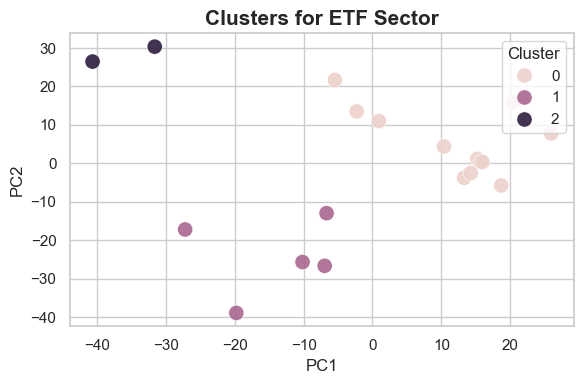

In [18]:
# k-means / PCA


scaler = StandardScaler()
returns_scaled = scaler.fit_transform(new_returns.T)

pca = PCA(n_components = 2)
pca_components = pca.fit_transform(returns_scaled)

max_clusters = min(len(etfs) - 1, 10)

best_k = 3
best_score = -1

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    labels = kmeans.fit_predict(pca_components)
    score = silhouette_score(pca_components, labels)

    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters = best_k, random_state = 42)
labels = kmeans.fit_predict(pca_components)

cluster_df = pd.DataFrame({
    'ETF': new_returns.columns,
    'Cluster': labels,
    'PC1': pca_components[:, 0],
    'PC2': pca_components[:, 1]
})

print(f'Clusters:')
print(cluster_df)

sns.set_theme(style = 'whitegrid', font_scale = 1)

plt.figure(figsize = (6, 4))

sns.scatterplot(
    data = cluster_df,
    x = 'PC1',        
    y = 'PC2',
    hue = 'Cluster',
    s = 120, 
    linewidth = 0.4,
    alpha = 0.9 
)

plt.title(f'Clusters for ETF Sector', fontsize = 15, weight = 'bold')
plt.xlabel('PC1', fontsize = 12)
plt.ylabel('PC2', fontsize = 12)

plt.legend(title = 'Cluster', loc='upper right', frameon = True)

plt.tight_layout()
plt.show()

cluster_df = cluster_df.sort_values(by = 'Cluster')

In [19]:
final_candidates = []

cluster_zip = dict(zip(cluster_df['ETF'], cluster_df['Cluster']))

for _, row in corr_filtered_pairs_df.iterrows():
    etf1, etf2, pass_percentage = row['ETF1'], row['ETF2'], row['Pass %']
    if cluster_zip[etf1] == cluster_zip[etf2]:
        final_candidates.append([etf1, etf2, pass_percentage, cluster_zip[etf1]])

final_candidates = pd.DataFrame(final_candidates, columns=['ETF1','ETF2','RC Pass %','Cluster #'])
final_candidates = final_candidates.sort_values('RC Pass %', ascending=False).reset_index(drop=True)
print(final_candidates)


   ETF1  ETF2  RC Pass %  Cluster #
0  SCHV  SPHQ   0.479167          0
1   VTV  SPHQ   0.437500          0
2   IWS   IJH   0.437500          1
3   DVY   FVD   0.416667          2
